In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
import seaborn as sns
import statsmodels.api as sm

/tmp/ipykernel_146293/1396264545.py:7: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr
/tmp/ipykernel_146293/1396264545.py:8: DeprecationWarning: Please import `spearmanr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import spearmanr


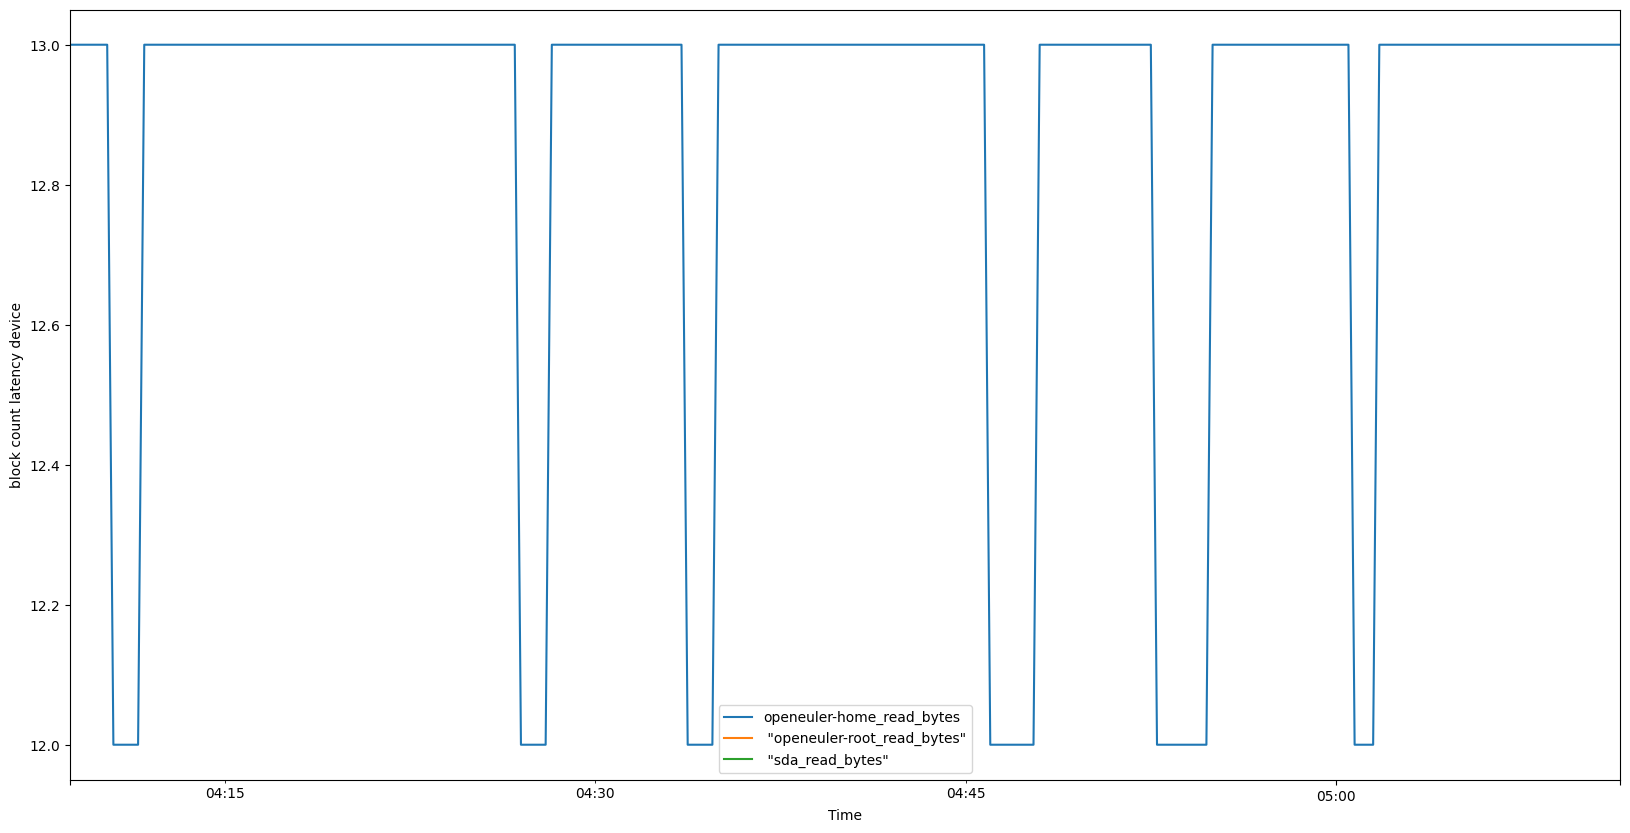

In [16]:
df = pd.read_csv('../datasets/block_count_latency_device.csv', parse_dates=['Time'], index_col='Time')


ax = df.plot(figsize=(20,10))
ax.set_ylabel('block count latency device')
plt.show()


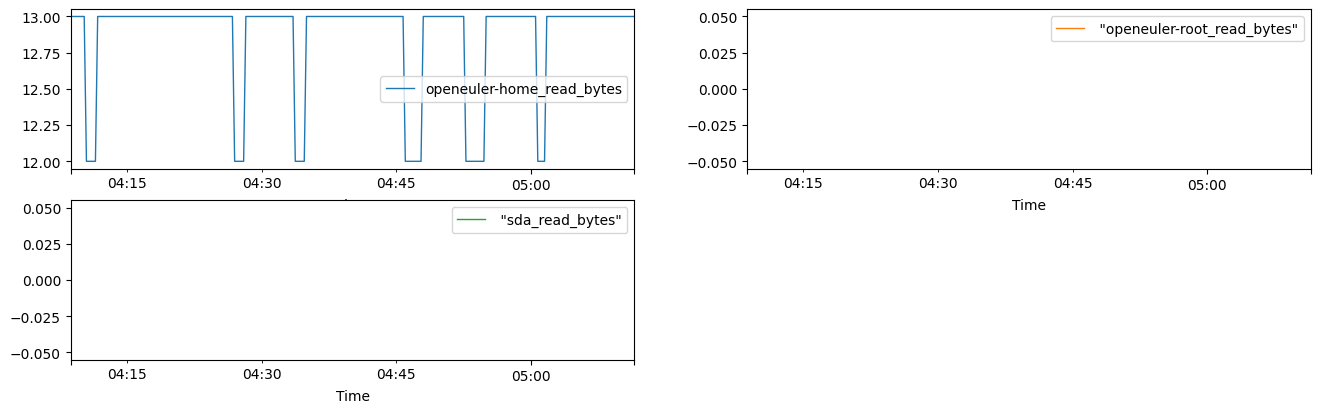

In [17]:
df.plot(subplots=True,
        linewidth=1,
        layout=(5,2),
        figsize=(16,12),
        sharex=False,
        sharey=False)
plt.show()

/tmp/ipykernel_146293/636100573.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current += x[i]
/tmp/ipykernel_146293/636100573.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current -= x[i-order]


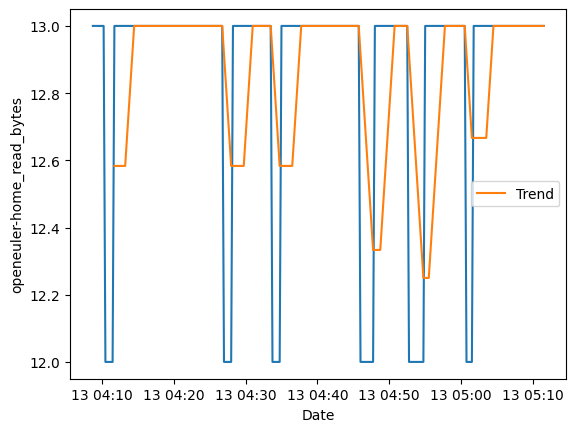

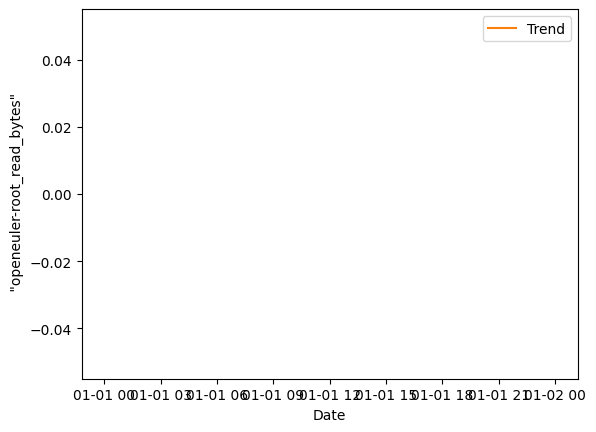

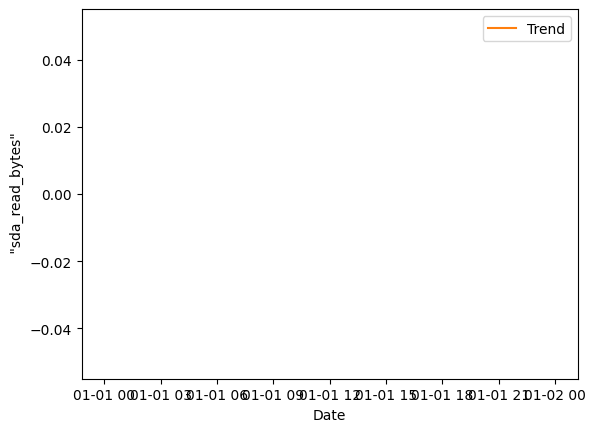

In [18]:
def running_average(x, order):
    current = x[:order].sum()
    running = []

    for i in range(order, x.shape[0]):
        current += x[i]
        current -= x[i-order]
        running.append(current/order)
    
    return np.array(running)

for feature in df.columns:
    trend = running_average(df[feature], 12)
    fig, ax = plt.subplots(1, 1)
    ax.plot(df.index, df[feature])
    ax.set_xlabel('Date')
    ax.set_ylabel(feature)
    ax.plot(df.index[12:], trend, label='Trend')
    ax.legend()

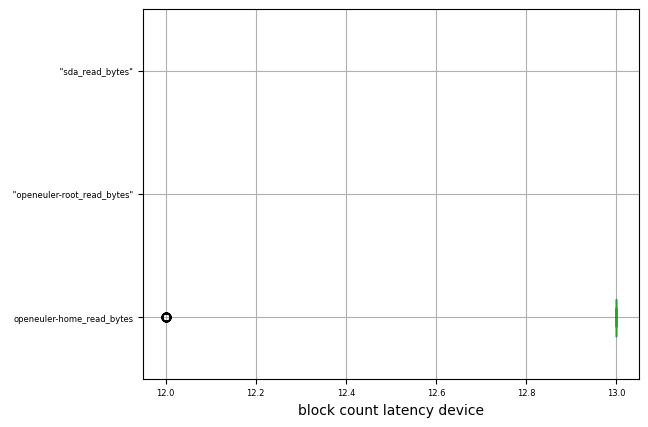

In [19]:
ax = df.boxplot(fontsize=6, vert=False)
ax.set_xlabel('block count latency device')
plt.show()

In [20]:
# Pearson correlation matrix
corr_p = df[df.columns].corr(method='pearson')
print('\nPearson correlation matrix')
print(corr_p)

# Spearman correlation matrix'
corr_s = df[df.columns].corr(method='spearman')
print('\nSpearman correlation matrix')
print(corr_s)


Pearson correlation matrix
                              openeuler-home_read_bytes  \
openeuler-home_read_bytes                           1.0   
 "openeuler-root_read_bytes"                        NaN   
 "sda_read_bytes"                                   NaN   

                               "openeuler-root_read_bytes"   "sda_read_bytes"  
openeuler-home_read_bytes                              NaN                NaN  
 "openeuler-root_read_bytes"                           NaN                NaN  
 "sda_read_bytes"                                      NaN                NaN  

Spearman correlation matrix
                              openeuler-home_read_bytes  \
openeuler-home_read_bytes                           1.0   
 "openeuler-root_read_bytes"                        NaN   
 "sda_read_bytes"                                   NaN   

                               "openeuler-root_read_bytes"   "sda_read_bytes"  
openeuler-home_read_bytes                              NaN           

<Axes: >

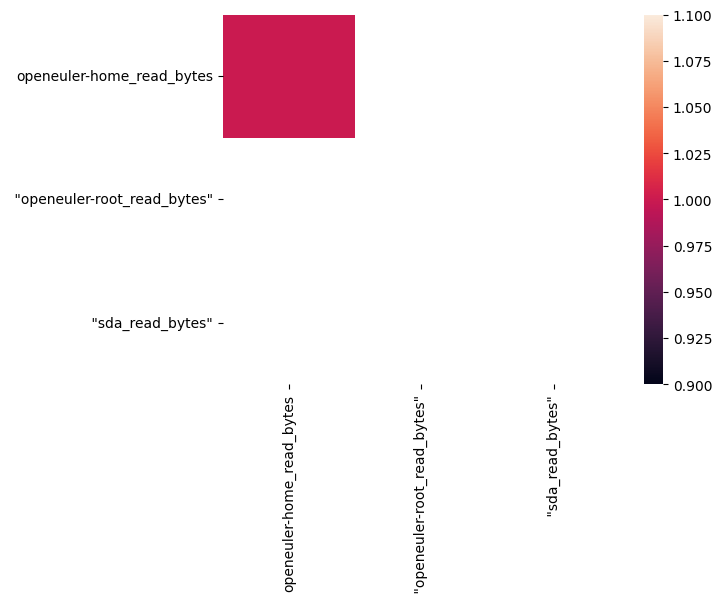

In [21]:
corr_mat = df.corr(method='pearson')
sns.heatmap(corr_mat)

<Axes: >

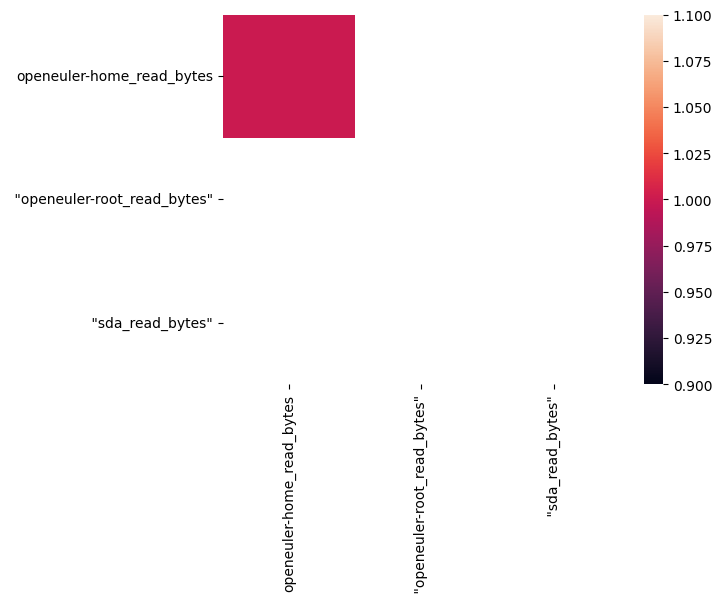

In [22]:
corr_mat_spearman = df.corr(method='spearman')
sns.heatmap(corr_mat_spearman)

In [23]:
dict_decompositions = {}
df.names = df.columns
print(df.names)


Index(['openeuler-home_read_bytes', ' "openeuler-root_read_bytes"',
       ' "sda_read_bytes"'],
      dtype='object')


/tmp/ipykernel_146293/2198433391.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.names = df.columns


In [24]:
for feature in df.names:
    feature_decomposition = sm.tsa.seasonal_decompose(df[feature], period=43)
    dict_decompositions[feature] = feature_decomposition

dict_trend = {}
dict_seasonal = {}
dict_resid = {}

for feature in df.names:
    dict_trend[feature] = dict_decompositions[feature].trend  #TODo Check the period and where to insert!
    dict_seasonal[feature] = dict_decompositions[feature].seasonal
    dict_resid[feature] = dict_decompositions[feature].resid

trend_df = pd.DataFrame.from_dict(dict_trend)
seasonal_df = pd.DataFrame.from_dict(dict_seasonal)
resid_df = pd.DataFrame.from_dict(dict_resid)

ValueError: This function does not handle missing values

In [ ]:
trend_df.plot(
    subplots=True,
    layout=(5,2),
    figsize=(17,10),
    sharex=True,
    sharey=False
)
plt.title('trend component of block count latency device dataset')

In [ ]:
resid_df.plot(
    subplots=True,
    layout=(5,2),
    figsize=(17,10),
    sharex=True,
    sharey=False
)
plt.title('residual component of block count latency device dataset')

In [25]:
trend_df.plot()
plt.title('trend of the feature in the dataset')

seasonal_df.plot()
plt.title('seasonal of the feature in the dataset')

resid_df.plot()
plt.title('residual of the feature in the dataset')

NameError: name 'trend_df' is not defined

In [ ]:


trend_corr = trend_df.corr(method='pearson')

# Customize the clustermap of the seasonality_corr
fig = sns.clustermap(trend_corr, annot=True, linewidth=0.5,figsize=(9,7))

plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

In [ ]:
trend_corr_spearman = trend_df.corr(method='spearman')

fig = sns.clustermap(trend_corr, annot=True, linewidth=0.4,figsize=(9,7))

plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)